# Detect and track developing DCCs in GOES-16 ABI data

This jupyter notebook provides an example of detecting developing convection and the connected anvil clouds by applying tobac-flow to 5-minute frequency GOES-16 CONUS scan ABI imagery.

The cell below contains configuration settings that you may change if, for example, you wish to save the data in a different location:

In [1]:
SAVE_PATH = "../data"
START_DATE = "2018-06-19 16:00:00"
HOURS = 4

In [2]:
import pathlib
from datetime import datetime, timedelta

import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
from scipy import ndimage as ndi
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from dateutil.parser import parse as parse_date

Core imports from tobac-flow: a dataloader for GOES ABI files, the "create_flow" function which returns a Flow object, detection functions for cores and anvils and a plotting function

In [3]:
from tobac_flow.dataloader import goes_dataloader
from tobac_flow.flow import create_flow
from tobac_flow.detection import detect_cores, get_anvil_markers, detect_anvils, relabel_anvils
from tobac_flow.plotting import goes_figure

ncdump [-c|-h] [-v ...] [[-b|-f] [c|f]] [-l len] [-n name] [-p n[,n]] [-k] [-x] [-s] [-t|-i] [-g ...] [-w] [-F] [-Ln] file
  [-c]             Coordinate variable data and header information
  [-h]             Header information only, no data
  [-v var1[,...]]  Data for variable(s) <var1>,... only
  [-b [c|f]]       Brief annotations for C or Fortran indices in data
  [-f [c|f]]       Full annotations for C or Fortran indices in data
  [-l len]         Line length maximum in data section (default 80)
  [-n name]        Name for netCDF (default derived from file name)
  [-p n[,n]]       Display floating-point values with less precision
  [-k]             Output kind of netCDF file
  [-s]             Output special (virtual) attributes
  [-t]             Output time data as date-time strings
  [-i]             Output time data as date-time strings with ISO-8601 'T' separator
  [-g grp1[,...]]  Data and metadata for group(s) <grp1>,... only
  [-w]             With client-side caching of va

In [4]:
# Ignore Runtimewarnings due to shapely/cartopy
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Loading and preparing GOES-16 data

First, we need to select a time period and region to track over. For this example, we will pick a region over Northern Florida

In [5]:
# Setup input args

hours = timedelta(hours=HOURS)

start_date = datetime.strptime(START_DATE, "%Y-%m-%d %H:%M:%S")
end_date = start_date + hours

satellite = 16

x0 = 1300
x1 = 1600
y0 = 600
y1 = 900

t_offset = 3

output_path = pathlib.Path(SAVE_PATH)

save_dir = output_path / "dcc_detect"
if not save_dir.exists():
    save_dir.mkdir(parents=True, exist_ok=True)

save_name = f'detected_dccs_G{satellite:02d}_S{start_date.strftime("%Y%m%d_%H0000")}_E{end_date.strftime("%Y%m%d_%H0000")}_X{x0:04d}_{x1:04d}_Y{y0:04d}_{y1:04d}.nc'

save_path = save_dir / save_name

print("Saving output to:", save_path)

goes_data_path = output_path / "GOES16"
if not goes_data_path.exists():
    goes_data_path.mkdir(parents=True, exist_ok=True)


Saving output to: ../data/dcc_detect/detected_dccs_G16_S20180619_160000_E20180619_200000_X1300_1600_Y0600_0900.nc


We can then find and load the required data using the goes dataloader. This will download files from the NOAA GCP bucket if they are not already stored locally

In [6]:
# Load ABI data
io_kwargs = {
    'satellite':satellite,
    'product':'MCMIP',
    'view':'C',
    'mode':[3,4,6],
    'save_dir':goes_data_path,
    'replicate_path':True,
    'check_download':True,
    'n_attempts':1,
    'download_missing':True
}

bt, wvd, swd, dataset = goes_dataloader(
    start_date, end_date, n_pad_files=0, x0=x0, x1=x1, y0=y0, y1=y1, return_new_ds=True, **io_kwargs
)

/Users/jonesw/python/tobac-flow/tobac_flow/dataloader.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Loading 48 files
Loaded 48 time steps


Visualise these fields:

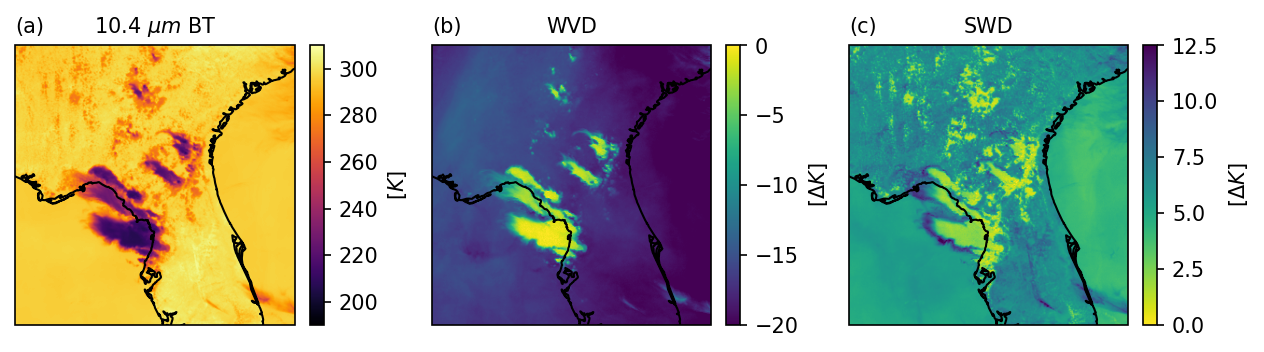

In [7]:
fig = goes_figure(dataset, dpi=150, figsize=(9,3))

ax1 = fig.subplot(131)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="inferno", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.set_title('(a)', loc='left', fontsize=10)
ax1.set_title('10.4 $\mu m$ BT', fontsize=10)

ax2 = fig.subplot(132)
ax2.coastlines()
im2 = ax2.imshow(wvd[36], cmap="viridis", vmin=-20, vmax=0)
cbar2 = ax2.colorbar(im2)
cbar2.set_label('[$\Delta K$]', fontsize=10)
ax2.set_title('(b)', loc='left', fontsize=10)
ax2.set_title('WVD', fontsize=10)

ax3 = fig.subplot(133)
ax3.coastlines()
im3 = ax3.imshow(swd[36], cmap="viridis_r", vmin=0, vmax=12.5)
cbar3 = ax3.colorbar(im3)
cbar3.set_label('[$\Delta K$]', fontsize=10)
ax3.set_title('(c)', loc='left', fontsize=10)
ax3.set_title('SWD', fontsize=10)

plt.subplots_adjust(hspace=0.1, bottom=0.1, top=0.85, left=0.075, right=0.95)

The 10.4 micron brightness temperature is in the longwave window band, so provides BT measurements throughout the troposphere. This is ideal for detecting cloud motion, as it shows the most contrast, and for detecting developing cores as they can be seen near the surface

The water vapour difference (WVD) is the difference of the 6.2 and 7.3 micron BT channels. The channels are sensitive to water vapour in the upper and lower troposphere, respectively. The difference of these channels is ideal for detecting thick, high clouds as they show strong contrast from the background and low level clouds have no effect.

The split window difference (SWD) is the difference of the 10.4 and 12.4 micron BT channels. Cloud ice has different emissivity at these two wavelengths, and so a large difference is seen for thin, high ice clouds. However, the 12.4 micron channel also has some sensivity to boundary layer water vapour, so this field is also affected by low level conditions. Using a difference of the 8.4 micron (mid-LW window) and the 10.4 or 12.4 micron channels may help alleviate this

# Detecting cloud top motion

The first step in using tobac-flow is to create a "flow" object. To create this object, we use the "create_flow" function to estimate the cloud top motion vectors. This object can then be used to perform detection and tracking in a semi-Lagrangian framework

In [8]:
# Generate flow field
flow = create_flow(bt, model="Farneback", vr_steps=1, smoothing_passes=1)

Visualise the Flow field

Text(0, 0.5, 'Distance along y axis [km]')

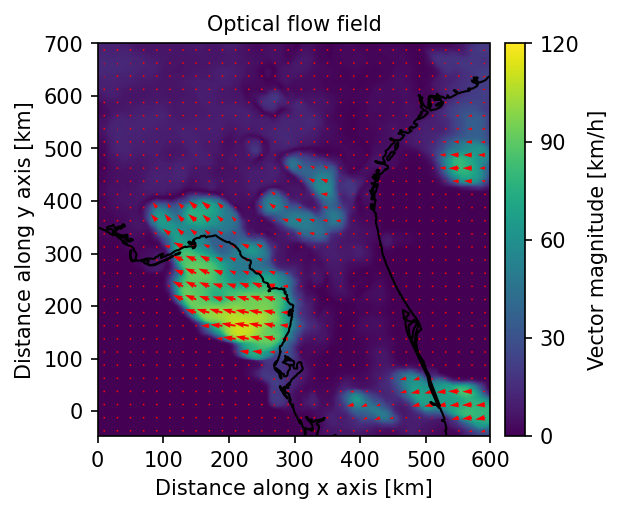

In [9]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

i=36
j=6

ax = fig.subplot(111)
ax.coastlines()
flow_magnitude = ((flow.forward_flow[i:i+j-1,...,0].mean(0)*2.5)**2 
                  + (flow.forward_flow[i:i+j-1,...,1].mean(0)*2)**2)**0.5 * 12
img = ax.imshow(flow_magnitude, vmin=0, vmax=120)
cbar = ax.colorbar(img)
cbar.set_label('Vector magnitude [km/h]', fontsize=10)
cbar.set_ticks([0,30,60,90,120])
q = ax.quiver(
    flow.forward_flow[i:i+j-1,...,0].mean(0), -flow.forward_flow[i:i+j-1,...,1].mean(0), 
    spacing=10, scale=100, width=0.005, color='r'
)
ax.set_title('Optical flow field', fontsize=10)
ax.set_xticks((bt.x*dataset.goes_imager_projection.perspective_point_height)[list(range(0,bt.x.size,50))+[-1]])
ax.set_xticklabels(np.arange(0,bt.x.size+1,50)*2)
ax.set_xlabel("Distance along x axis [km]", fontsize=10)
ax.set_yticks((bt.y*dataset.goes_imager_projection.perspective_point_height)[list(range(0,bt.y.size,40))])
ax.set_yticklabels((np.arange(0,bt.y.size+1,40)[::-1]*2.5).astype(int))
ax.set_ylabel("Distance along y axis [km]", fontsize=10)


# Core detection

Growing cores are detected using regions of cooling cloud top temperature:

In [10]:
core_labels = detect_cores(flow, bt, wvd, swd)

WVD growth above threshold: area = 7677
BT growth above threshold: area = 21660
Detected markers: area = 13674
Initial core count: 239
Core labels meeting length threshold: 44
Core labels meeting WVD threshold: 135
Core labels meeting cooling rate threshold: 41


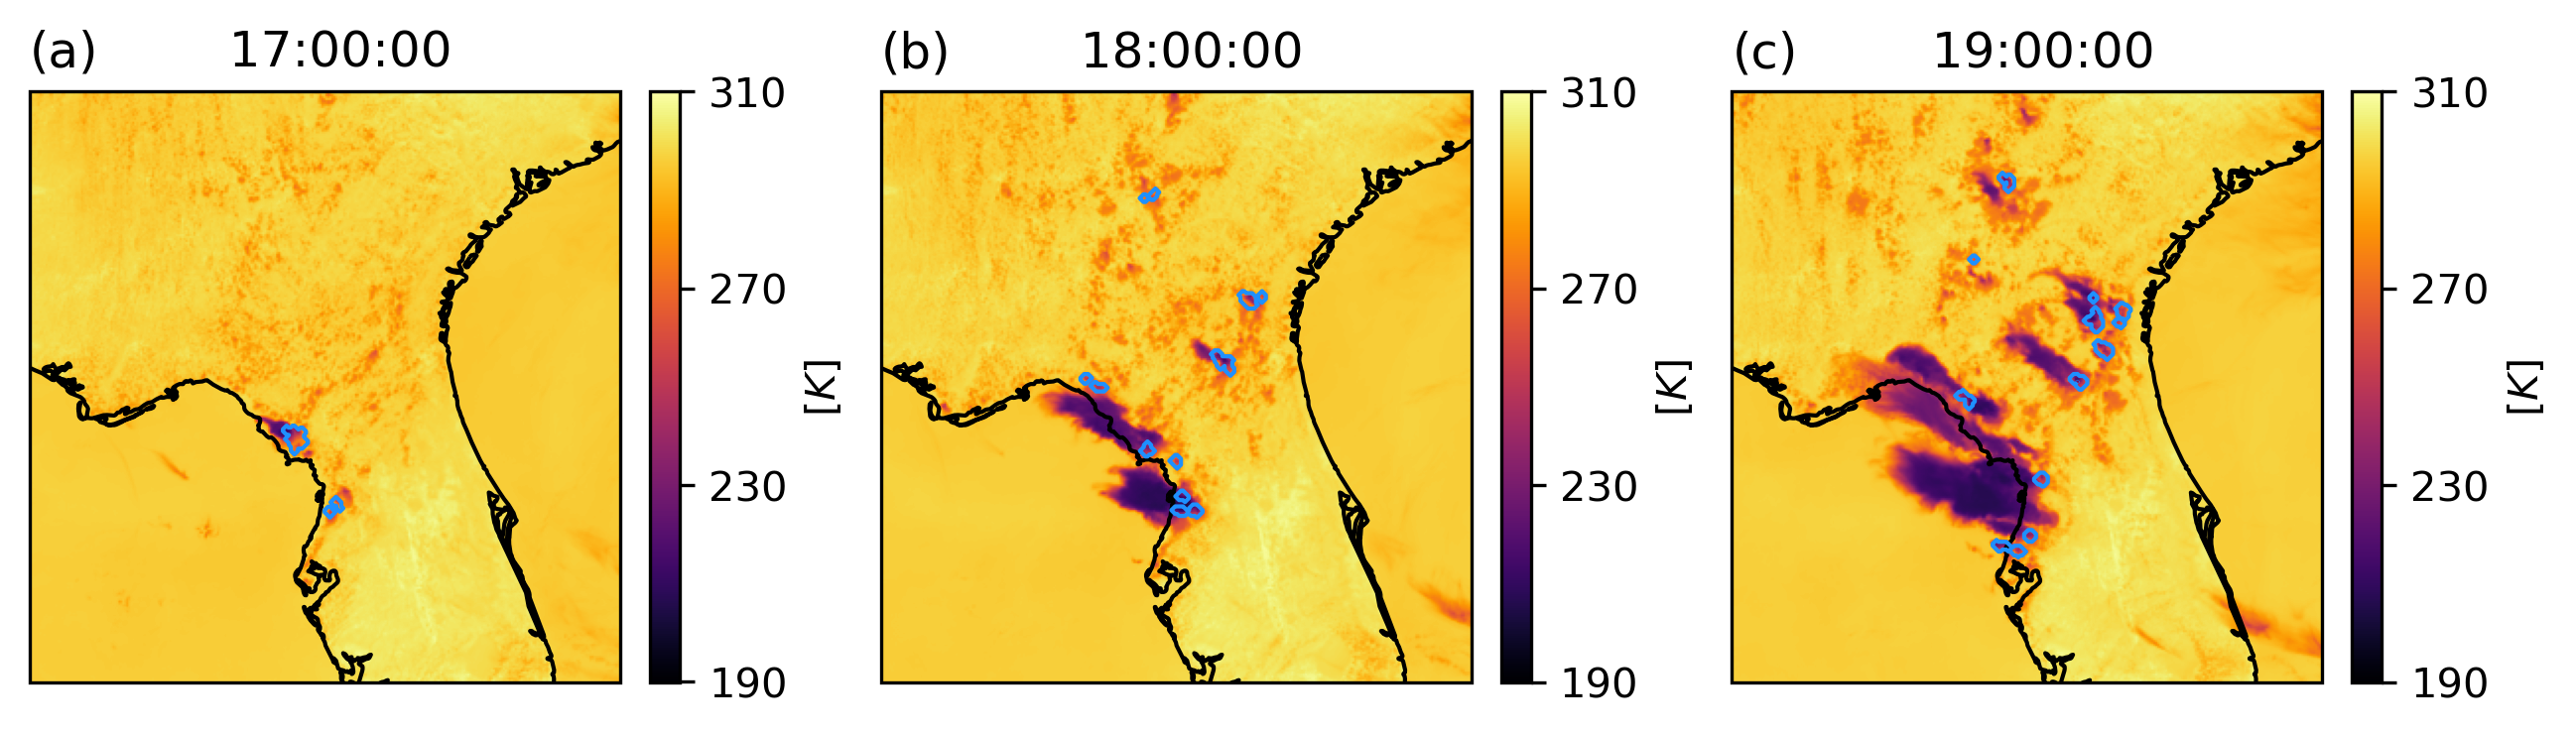

In [11]:
fig = goes_figure(dataset, dpi=300, figsize=(9,3))

i1=12
ax1 = fig.subplot(131)
ax1.coastlines()
img = ax1.imshow(bt[i1], vmin=190, vmax=310, cmap='inferno')
cbar = ax1.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax1.set_title('(a)', loc='left')
ax1.set_title('  17:00:00')

ax1.contour(core_labels[i1], [0.5], colors=['dodgerblue'], linewidths=[1])

i2=24
ax2 = fig.subplot(132)
ax2.coastlines()
img = ax2.imshow(bt[i2], vmin=190, vmax=310, cmap='inferno')
cbar = ax2.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax2.set_title('(b)', loc='left')
ax2.set_title('  18:00:00')

ax2.contour(core_labels[i2], [0.5], colors=['dodgerblue'], linewidths=[1])

i3=36
ax3 = fig.subplot(133)
ax3.coastlines()
img = ax3.imshow(bt[i3], vmin=190, vmax=310, cmap='inferno')
cbar = ax3.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax3.set_title('(c)', loc='left')
ax3.set_title('  19:00:00')

ax3.contour(core_labels[i3], [0.5], colors=['dodgerblue'], linewidths=[1])

plt.subplots_adjust(bottom=0.05, hspace=0.1, left=0)

The following is a demonstration of how core detection works

First, we calculate the growth rate (negative cooling rate) of the 10.4 micron BT and WVD fields

In [12]:
# Calculate growth fields
from tobac_flow.detection import get_growth_rate
wvd_growth = get_growth_rate(flow, wvd, method="cubic")
bt_growth = get_growth_rate(flow, -bt, method="cubic")

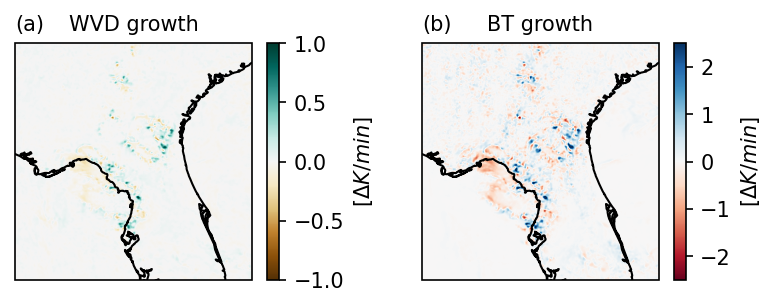

In [13]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(121)
ax1.coastlines()
im1 = ax1.imshow(wvd_growth[36], cmap="BrBG", vmax=1, vmin=-1)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$\Delta K/min$]', fontsize=10)
ax1.set_title('(a)', loc='left', fontsize=10)
ax1.set_title('WVD growth', fontsize=10)

ax2 = fig.subplot(122)
ax2.coastlines()
im2 = ax2.imshow(bt_growth[36], cmap="RdBu", vmin=-2.5, vmax=2.5)
cbar2 = ax2.colorbar(im2)
cbar2.set_label('[$\Delta K/min$]', fontsize=10)
ax2.set_title('(b)', loc='left', fontsize=10)
ax2.set_title('BT growth', fontsize=10)

plt.subplots_adjust(wspace=0.4)

To remove erroneus growth rates from regions other than developing cores, we apply a filter that finds minima in the two fields.

In [14]:
# Calculate curvature filters and detect cores
from tobac_flow.detection import get_combined_filters
combined_filter = get_combined_filters(flow, bt, wvd, swd)

We then find the initial core regions by applying thresholds to the growth rates:

In [15]:
wvd_threshold = 0.25
bt_threshold = 0.5

wvd_markers = (wvd_growth * combined_filter) > wvd_threshold
bt_markers =  (bt_growth * combined_filter) > bt_threshold

s_struct = ndi.generate_binary_structure(3,1)
s_struct *= np.array([0,1,0])[:,np.newaxis, np.newaxis].astype(bool)

combined_markers = ndi.binary_opening(
    np.logical_or(wvd_markers, bt_markers), structure=s_struct
)

print('WVD growth above threshold: area =', np.sum(wvd_markers))
print('BT growth above threshold: area =', np.sum(bt_markers))
print('Detected markers: area =', np.sum(combined_markers))


WVD growth above threshold: area = 7677
BT growth above threshold: area = 21660
Detected markers: area = 13674


We then link these detection regions into unique cores

In [16]:
overlap = 0.5
absolute_overlap = 4
subsegment_shrink = 0.0

core_labels = flow.label(
    combined_markers,
    overlap=overlap,
    absolute_overlap=absolute_overlap,
    subsegment_shrink=subsegment_shrink,
)

print("Initial core count:", np.max(core_labels))

Initial core count: 239


These initial labels then require filtering to ensure that they meet several criteria (lifetime, WVD threshold and maximum cooling rate)

In [17]:
# Filter labels by length and wvd growth threshold
from tobac_flow.analysis import find_object_lengths, mask_labels, remap_labels
from tobac_flow.utils import labeled_comprehension, slice_labels

min_length=3

core_label_lengths = find_object_lengths(core_labels)

print("Core labels meeting length threshold:", np.sum(core_label_lengths>t_offset))

core_label_wvd_mask = mask_labels(core_labels, wvd > -5)

print("Core labels meeting WVD threshold:", np.sum(core_label_wvd_mask))

combined_mask = np.logical_and(core_label_lengths > min_length, core_label_wvd_mask)

# Now we need to slice the labels to calculate the cooling rates over time
core_labels = remap_labels(core_labels, combined_mask)

core_step_labels = slice_labels(core_labels)

mode = lambda x : stats.mode(x, keepdims=False)[0]
core_step_core_index = labeled_comprehension(
    core_labels, core_step_labels, mode, default=0
)

core_step_bt_mean = labeled_comprehension(
    bt, core_step_labels, np.nanmean, default=np.nan
)

core_step_t = labeled_comprehension(
    bt.t.data[:, np.newaxis, np.newaxis], core_step_labels, np.nanmin, default=0
)

def bt_diff_func(step_bt, pos):
    step_t = core_step_t[pos]
    args = np.argsort(step_t)

    step_bt = step_bt[args]
    step_t = step_t[args]
    
    step_bt_diff = (
        (step_bt[:-t_offset] - step_bt[t_offset:])
         / ((step_t[t_offset:] - step_t[:-t_offset]).astype("timedelta64[s]").astype("int")/60)
    )

    return np.nanmax(step_bt_diff)

core_bt_diff_mean = labeled_comprehension(
    core_step_bt_mean, core_step_core_index, bt_diff_func, default=0, pass_positions=True
)

wh_valid_core = core_bt_diff_mean>=0.5

print("Core labels meeting cooling rate threshold:", np.sum(wh_valid_core))

core_labels = remap_labels(core_labels, wh_valid_core)

print('Final detected core count: n =', core_labels.max())


Core labels meeting length threshold: 44
Core labels meeting WVD threshold: 135
Core labels meeting cooling rate threshold: 41
Final detected core count: n = 41


Text(0.5, 1.0, '10.8 $\\mu m$ BT')

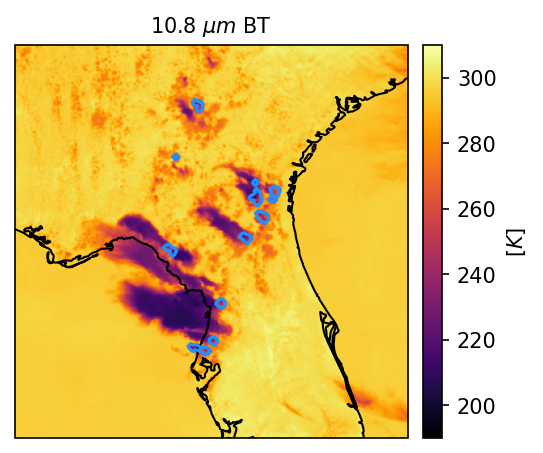

In [18]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="inferno", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.contour(core_labels[36], [0.5], colors=["dodgerblue"])
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)


# Validation of core detection

To validate the core detection method, we compare it to column mean radar reflectivities from NEXRAD

Note: this requires significant additional data download and processing, so you may wish to skip this step

In [19]:
# Get Nexrad data
nexrad_data_path = output_path / "nexrad_l2"
regridded_nexrad_file = output_path / "nexrad_regrid_v2.nc"
if regridded_nexrad_file.exists():
    with xr.open_dataset(regridded_nexrad_file) as ref_ds:
        ref_grid = ref_ds.ref_grid
        ref_mask = ref_ds.ref_grid
else:
    from tobac_flow import nexrad, io
    print('Finding NEXRAD data')
    nexrad_sites = nexrad.filter_nexrad_sites(dataset, extend=0.001)
    print("Number of sites in bound: %d" % len(nexrad_sites))
    dates = pd.date_range(start_date, end_date, freq="h", inclusive="left")
    nexrad_files = sum([sum([io.find_nexrad_files(date, site, save_dir=str(nexrad_data_path), download_missing=True)
                             for site in nexrad_sites], [])
                        for date in dates], [])
    print(f"Loading {len(nexrad_files)} NEXRAD files")
    # Regrid nexrad - note that this is a lengthly operation, expect it to take ~1 hour for the example here
    # TODO; make pre-processed regridded nexrad file available.
    ref_grid, ref_mask = nexrad.regrid_nexrad(nexrad_files, dataset, min_alt=500)
    ref_ds = xr.Dataset(data_vars={'ref_grid':ref_grid, 'ref_mask':ref_mask})
    ref_ds.to_netcdf(regridded_nexrad_file)

In [20]:
ref_grid

<xarray.DataArray 'ref_grid' (t: 104, y: 300, x: 300)> Size: 75MB
[9360000 values with dtype=float64]
Coordinates:
  * t        (t) datetime64[ns] 832B 2018-06-19T15:43:43.224569984 ... 2018-0...
  * y        (y) float32 1kB 0.09461 0.09456 0.0945 ... 0.07798 0.07792 0.07787
  * x        (x) float32 1kB -0.02853 -0.02848 -0.02842 ... -0.01184 -0.01179

Text(0.5, 1.0, 'NEXRAD Column Reflectivity')

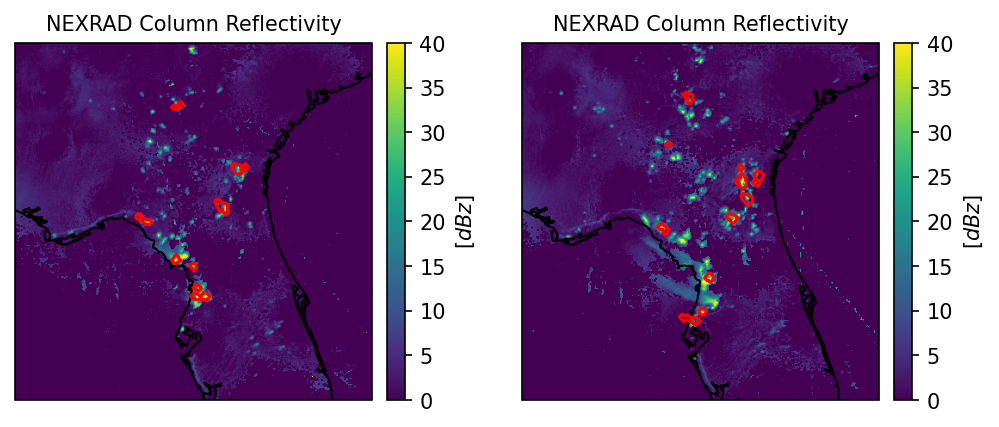

In [21]:
fig = goes_figure(dataset, dpi=150, figsize=(8,4))

ax1 = fig.subplot(121)
ax1.coastlines()
im1 = ax1.imshow(ref_grid[24], cmap="viridis", vmin=0, vmax=40)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$dBz$]', fontsize=10)
ax1.contour(core_labels[24], [0.5], colors=["r"])
ax1.set_title('NEXRAD Column Reflectivity', fontsize=10)


ax2 = fig.subplot(122)
ax2.coastlines()
im2 = ax2.imshow(ref_grid[36], cmap="viridis", vmin=0, vmax=40)
cbar2 = ax2.colorbar(im2)
cbar2.set_label('[$dBz$]', fontsize=10)
ax2.contour(core_labels[36], [0.5], colors=["r"])
ax2.set_title('NEXRAD Column Reflectivity', fontsize=10)


We see that the detected regions correspond well with regions of high radar reflectivity. However, once the core is no longer growing vertically we cannot detect the core using cooling rates, so later stages of the core are often missed

# Anvil detection

Next up is anvil detection. We can do this either using the detected cores as a starting point, or independently. In the latter case, it is good practice to then remove any anvils detected without associated cores

We can start with the thick anvil region, which we use an upper and lower threshold to detect:

In [22]:
upper_threshold = -5
lower_threshold = -12.5
erode_distance = 2

field = wvd - np.maximum(swd, 0)

# Find initial markers when wvd - swd is greater than upper threshold
anvil_markers = get_anvil_markers(
    flow,
    field,
    threshold=upper_threshold,
    overlap=overlap,
    absolute_overlap=absolute_overlap,
    subsegment_shrink=subsegment_shrink,
    min_length=t_offset,
)

print("Final thick anvil markers: area =", np.sum(anvil_markers != 0), flush=True)
print("Final thick anvil markers: n =", anvil_markers.max(), flush=True)

# Then watershed to detect anvil extent between the upper and lower thresholds:

thick_anvil_labels = detect_anvils(
    flow,
    field,
    markers=anvil_markers,
    upper_threshold=upper_threshold,
    lower_threshold=lower_threshold,
    erode_distance=erode_distance,
    min_length=t_offset,
)

print(
    "Initial detected thick anvils: area =",
    np.sum(thick_anvil_labels != 0),
    flush=True,
)
print("Initial detected thick anvils: n =", thick_anvil_labels.max(), flush=True)

Final thick anvil markers: area = 56152
Final thick anvil markers: n = 11
Initial detected thick anvils: area = 102599
Initial detected thick anvils: n = 11


To ensure a minimum overlap between time steps, and merge neighbouring anvils, we perform a relabelling operation:

In [23]:
thick_anvil_labels = relabel_anvils(
    flow,
    thick_anvil_labels,
    markers=anvil_markers,
    overlap=overlap,
    absolute_overlap=absolute_overlap,
    min_length=t_offset,
)

print(
    "Final detected thick anvils: area =",
    np.sum(thick_anvil_labels != 0),
    flush=True,
)
print("Final detected thick anvils: n =", thick_anvil_labels.max(), flush=True)

Final detected thick anvils: area = 102540
Final detected thick anvils: n = 11


Then, using the thick anvil region as a base, we can detect the thin anvil surrounding it:

In [24]:
upper_threshold = 0
lower_threshold = -7.5

field = wvd + np.maximum(swd, 0)

thin_anvil_labels = detect_anvils(
    flow,
    wvd + swd,
    markers=thick_anvil_labels,
    upper_threshold=upper_threshold,
    lower_threshold=lower_threshold,
    erode_distance=erode_distance,
    min_length=t_offset,
)

print("Detected thin anvils: area =", np.sum(thin_anvil_labels != 0), flush=True)
print("Detected thin anvils: n =", np.max(thin_anvil_labels), flush=True)

Detected thin anvils: area = 174798
Detected thin anvils: n = 11


We can now visualise what the two anvil areas look like:

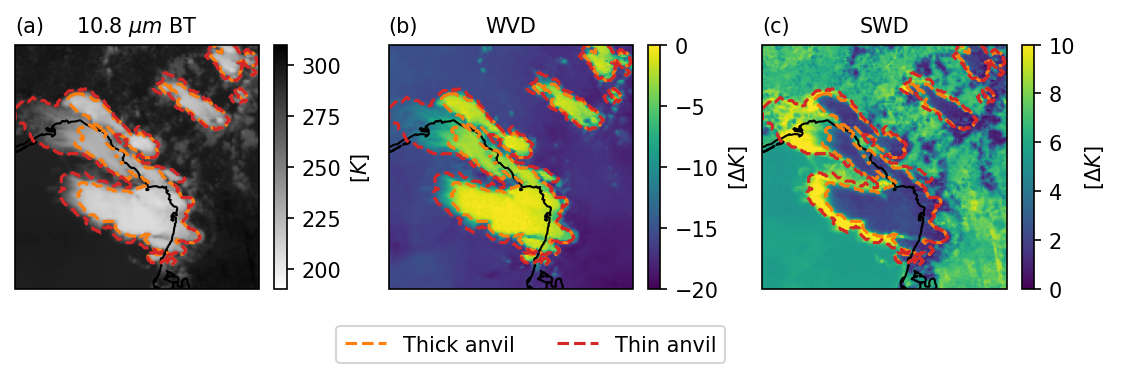

In [25]:
fig = goes_figure(dataset.isel(x=slice(50,200), y=slice(100,250)), dpi=150, figsize=(9,3))

ax1 = fig.subplot(131)
ax1.coastlines()
im1 = ax1.imshow(bt[36].isel(x=slice(50,200), y=slice(100,250)), cmap="binary", vmin=190, vmax=310)
ax1.contour(thick_anvil_labels[36][100:250, 50:200], [0.5], colors=["C1"], linestyles="--")
ax1.contour(thin_anvil_labels[36][100:250, 50:200], [0.5], colors=["C3"], linestyles="--")
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.set_title('(a)', loc='left', fontsize=10)
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax2 = fig.subplot(132)
ax2.coastlines()
im2 = ax2.imshow(wvd[36].isel(x=slice(50,200), y=slice(100,250)), cmap="viridis", vmin=-20, vmax=0)
ax2.contour(thick_anvil_labels[36][100:250, 50:200], [0.5], colors=["C1"], linestyles="--")
ax2.contour(thin_anvil_labels[36][100:250, 50:200], [0.5], colors=["C3"], linestyles="--")
cbar2 = ax2.colorbar(im2)
cbar2.set_label('[$\Delta K$]', fontsize=10)
ax2.set_title('(b)', loc='left', fontsize=10)
ax2.set_title('WVD', fontsize=10)

ax3 = fig.subplot(133)
ax3.coastlines()
im3 = ax3.imshow(swd[36].isel(x=slice(50,200), y=slice(100,250)), cmap="viridis", vmin=0, vmax=10)
ax3.contour(thick_anvil_labels[36][100:250, 50:200], [0.5], colors=["C1"], linestyles="--")
ax3.contour(thin_anvil_labels[36][100:250, 50:200], [0.5], colors=["C3"], linestyles="--")
cbar3 = ax3.colorbar(im3)
cbar3.set_label('[$\Delta K$]', fontsize=10)
ax3.set_title('(c)', loc='left', fontsize=10)
ax3.set_title('SWD', fontsize=10)

fig.legend([mlines.Line2D([], [], color='C1', linestyle="--"), mlines.Line2D([], [], color='C3', linestyle="--")], 
           ['Thick anvil', 'Thin anvil'], loc=[0.3,0.05], ncol=2)

plt.subplots_adjust(wspace=0.25)

We can see how the thick anvil consists of the area of cold BT, whereas the thin anvil also encompasses the area of high SWD where the BT is warmer

Now let's look further at how these functions work

First, we calculate the sobel edge gradients between the upper and lower thresholds:

In [26]:
# Detect anvil markers
from tobac_flow.utils import linearise_field

upper_threshold = -5
lower_threshold = -12.5
erode_distance = 2

# Linearise the difference field between 0 and 1
field = linearise_field(
    (wvd - np.maximum(swd, 0)).values, 
    lower_threshold, upper_threshold
)

structure = ndi.generate_binary_structure(3,1)
s_struct = structure * np.array([0,1,0])[:,np.newaxis, np.newaxis].astype(bool)

edges = flow.sobel(field, direction='uphill', method='linear')

Let's visualise the detected field and edge magnitudes:

Text(0.5, 1.0, 'Edges')

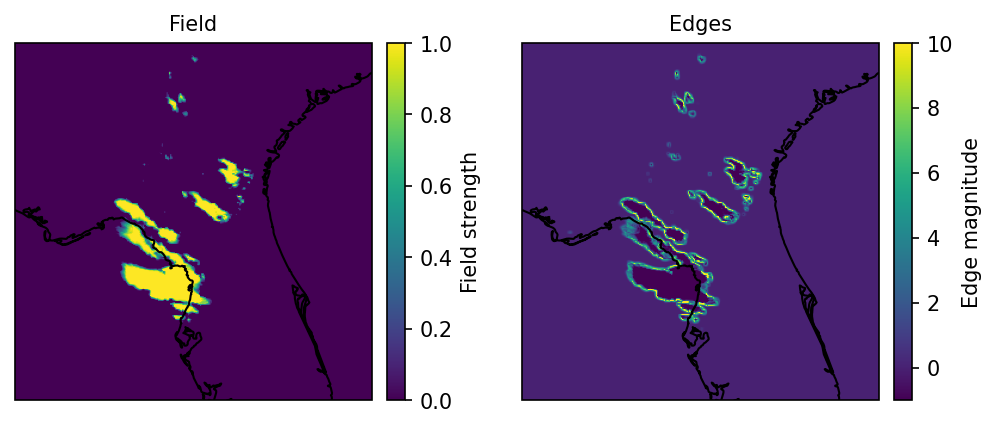

In [27]:
fig = goes_figure(dataset, dpi=150, figsize=(8,4))

ax1 = fig.subplot(121)
ax1.coastlines()
im1 = ax1.imshow(field[36], cmap="viridis", vmin=0, vmax=1)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('Field strength', fontsize=10)
ax1.set_title('Field', fontsize=10)

ax2 = fig.subplot(122)
ax2.coastlines()
im2 = ax2.imshow(edges[36]-field[36], cmap="viridis", vmin=-1, vmax=10)
cbar2 = ax2.colorbar(im2)
cbar2.set_label('Edge magnitude', fontsize=10)
ax2.set_title('Edges', fontsize=10)


Detection of marker labels finds where the field equals the maximum threshold, labels those areas and then filters out those which are shorter than a certain length:

In [28]:
markers = field>=1
markers = ndi.binary_opening(markers, structure=s_struct)

marker_labels = flow.label(
    markers, overlap=overlap, absolute_overlap=absolute_overlap, subsegment_shrink=subsegment_shrink
)

print('Initial detected thick anvil markers: area =', np.sum(marker_labels!=0), flush=True)
print('Initial detected thick anvil markers: n =', marker_labels.max(), flush=True)

marker_label_lengths = find_object_lengths(marker_labels)

marker_labels = remap_labels(
    marker_labels, marker_label_lengths>t_offset
)

print('Final detected thick anvil markers: area =', np.sum(marker_labels!=0), flush=True)
print('Final detected thick anvil markers: n =', marker_labels.max(), flush=True)


Initial detected thick anvil markers: area = 56357
Initial detected thick anvil markers: n = 27
Final detected thick anvil markers: area = 56152
Final detected thick anvil markers: n = 11


A mask region is also created for regions where the field value is less than the lower threshold:

In [29]:
wh_field_nan = np.isnan(field)
mask = np.logical_or(field <= 0, wh_field_nan)
mask = ndi.binary_erosion(
    mask,
    structure=np.ones([3, 3, 3]),
    iterations=erode_distance,
    border_value=1,
)
mask[wh_field_nan] = True


Text(0.5, 1.0, 'Anvil markers and mask extent')

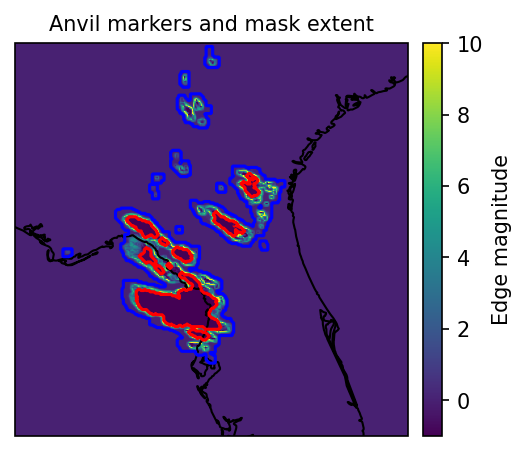

In [30]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(edges[36]-field[36], cmap="viridis", vmin=-1, vmax=10)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('Edge magnitude', fontsize=10)
ax1.contour(marker_labels[36], [0.5], colors=["r"])
ax1.contour(mask[36], [0.5], colors=["b"])
ax1.set_title('Anvil markers and mask extent', fontsize=10)


To detect the anvil extent between the thick and thin threshold, we can then perform a watershed segmentation:

In [31]:
# Perform watershed operation
eroded_markers = marker_labels * ndi.binary_erosion(
    markers != 0, structure=s_struct
).astype(int)

eroded_markers[mask] = -1

edges[np.isnan(field)] = np.inf

thick_anvil_labels = flow.watershed(
    edges,
    eroded_markers,
    mask=None,
    connectivity=ndi.generate_binary_structure(3, 1),
)
print('Initial detected thick anvils: area =', np.sum(thick_anvil_labels>0), flush=True)
print('Initial detected thick anvils: n =', thick_anvil_labels.max(), flush=True)

thick_anvil_labels = np.maximum(thick_anvil_labels, 0)

wh_markers = marker_labels > 0
thick_anvil_labels[wh_markers] = marker_labels[wh_markers]

marker_label_lengths = find_object_lengths(thick_anvil_labels)
marker_label_threshold = mask_labels(thick_anvil_labels, marker_labels > 0)

thick_anvil_labels = remap_labels(
    thick_anvil_labels,
    np.logical_and(marker_label_lengths > min_length, marker_label_threshold),
)

print('Final detected thick anvils: area =', np.sum(thick_anvil_labels!=0), flush=True)
print('Final detected thick anvils: n =', thick_anvil_labels.max(), flush=True)


Initial detected thick anvils: area = 102133
Initial detected thick anvils: n = 11
Final detected thick anvils: area = 102133
Final detected thick anvils: n = 11


Text(0.5, 1.0, '10.8 $\\mu m$ BT')

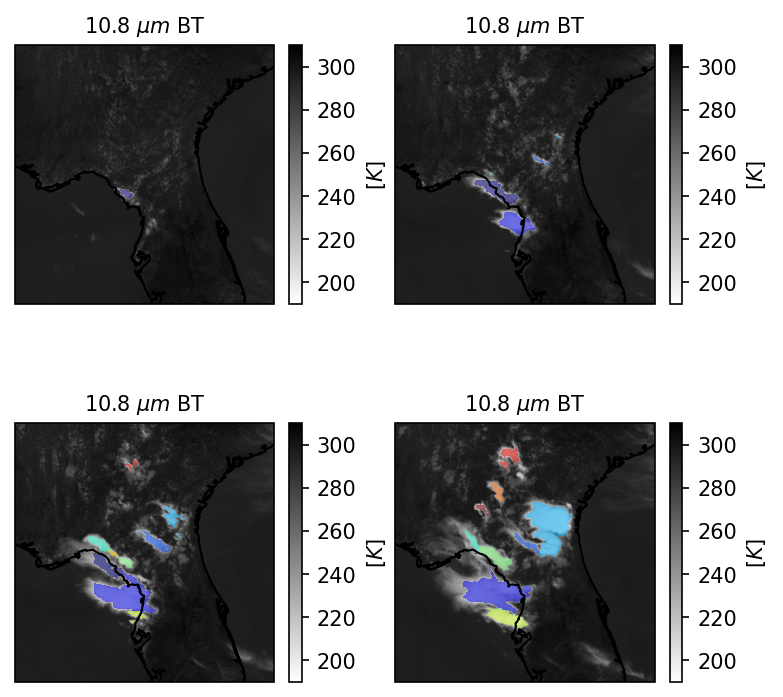

In [32]:
fig = goes_figure(dataset, dpi=150, figsize=(6,6))

ax1 = fig.subplot(221)
ax1.coastlines()
im1 = ax1.imshow(bt[12], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(thick_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_labels, mask=thick_anvil_labels==0)[12], cmap="jet", alpha=0.5, vmin=1, vmax=thick_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(222)
ax1.coastlines()
im1 = ax1.imshow(bt[24], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(thick_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_labels, mask=thick_anvil_labels==0)[24], cmap="jet", alpha=0.5, vmin=1, vmax=thick_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(223)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(thick_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_labels, mask=thick_anvil_labels==0)[36], cmap="jet", alpha=0.5, vmin=1, vmax=thick_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(224)
ax1.coastlines()
im1 = ax1.imshow(bt[-1], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(thick_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_labels, mask=thick_anvil_labels==0)[-1], cmap="jet", alpha=0.5, vmin=1, vmax=thick_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

We can also visualise the individual step labels for each anvil:

In [33]:
# Make unique labels for each time step
from tobac_flow.utils import make_step_labels
thick_anvil_step_labels = make_step_labels(thick_anvil_labels)

Text(0.5, 1.0, '10.8 $\\mu m$ BT')

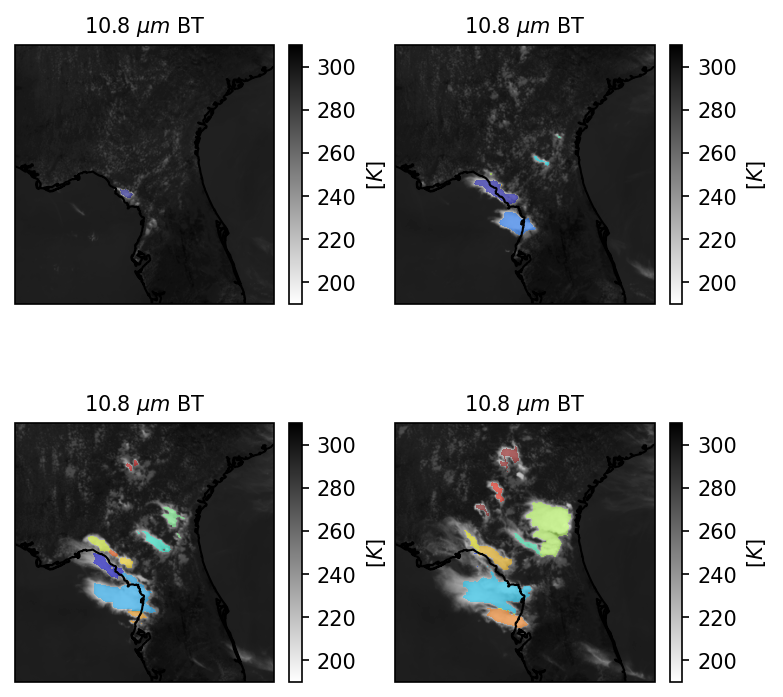

In [34]:
fig = goes_figure(dataset, dpi=150, figsize=(6,6))

ax1 = fig.subplot(221)
ax1.coastlines()
im1 = ax1.imshow(bt[12], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(initial_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_step_labels, mask=thick_anvil_step_labels==0)[12], cmap="jet", alpha=0.5, vmin=1, vmax=thick_anvil_step_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(222)
ax1.coastlines()
im1 = ax1.imshow(bt[24], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(initial_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_step_labels, mask=thick_anvil_step_labels==0)[24], cmap="jet", alpha=0.5, vmin=1, vmax=thick_anvil_step_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(223)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(initial_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_step_labels, mask=thick_anvil_step_labels==0)[36], cmap="jet", alpha=0.5, vmin=1, vmax=thick_anvil_step_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(224)
ax1.coastlines()
im1 = ax1.imshow(bt[-1], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(initial_watershed[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_step_labels, mask=thick_anvil_step_labels==0)[-1], cmap="jet", alpha=0.5, vmin=1, vmax=thick_anvil_step_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

To avoid spurious links between labels, and ensure that features with more than the required overlap are merged together, we can perform a relabelling operation:

In [35]:
from tobac_flow.label import flow_link_overlap

thick_anvil_labels = flow_link_overlap(flow, thick_anvil_step_labels, overlap=0.5)

marker_label_lengths = find_object_lengths(thick_anvil_labels)
marker_label_threshold = mask_labels(thick_anvil_labels, core_labels!=0)

thick_anvil_labels = remap_labels(
    thick_anvil_labels,
    np.logical_and(marker_label_lengths>t_offset, marker_label_threshold)
)

print('Final detected thick anvils: area =', np.sum(thick_anvil_labels!=0), flush=True)
print('Final detected thick anvils: n =', thick_anvil_labels.max(), flush=True)


Final detected thick anvils: area = 102133
Final detected thick anvils: n = 7


Text(0.5, 1.0, '10.8 $\\mu m$ BT')

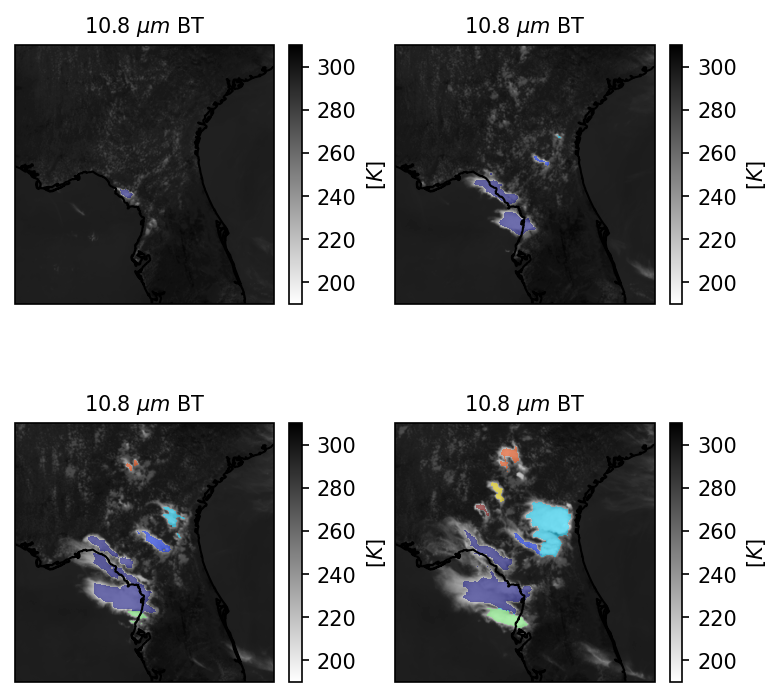

In [36]:
fig = goes_figure(dataset, dpi=150, figsize=(6,6))

ax1 = fig.subplot(221)
ax1.coastlines()
im1 = ax1.imshow(bt[12], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(thick_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_labels, mask=thick_anvil_labels==0)[12], cmap="jet", alpha=0.5, vmin=1, vmax=thick_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(222)
ax1.coastlines()
im1 = ax1.imshow(bt[24], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(thick_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_labels, mask=thick_anvil_labels==0)[24], cmap="jet", alpha=0.5, vmin=1, vmax=thick_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(223)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(thick_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_labels, mask=thick_anvil_labels==0)[36], cmap="jet", alpha=0.5, vmin=1, vmax=thick_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(224)
ax1.coastlines()
im1 = ax1.imshow(bt[-1], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(thick_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thick_anvil_labels, mask=thick_anvil_labels==0)[-1], cmap="jet", alpha=0.5, vmin=1, vmax=thick_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

Next, we detect and segment the thin anvil area. To do this, we repeat the watershed segmentation using the thick anvil labels as the initial markers, and WVD + SWD as the field to perform detection on. To account for the background values of the SWD field, we add 5 to both of the thresholds

In [41]:
# Detect thin anvil regions
upper_threshold = 0
lower_threshold = -7.5
erode_distance = 2

field = linearise_field(
    (wvd + swd).values, 
    lower_threshold, upper_threshold
)

edges = flow.sobel(field, direction='uphill', method='linear')

edges[np.isnan(field)] = np.inf

Here is the edge field used to detect the extent of the thin anvil:

Text(0.5, 1.0, 'Thin anvil edges')

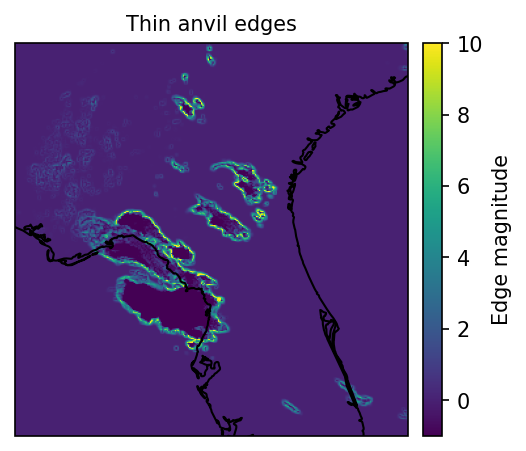

In [42]:
fig = goes_figure(dataset, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(edges[36]-field[36], cmap="viridis", vmin=-1, vmax=10)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('Edge magnitude', fontsize=10)
ax1.set_title('Thin anvil edges', fontsize=10)


In [44]:
# Perform watershed operation
structure = ndi.generate_binary_structure(3,1)
s_struct = structure * np.array([0,1,0])[:,np.newaxis, np.newaxis].astype(bool)

mask = ndi.binary_erosion(
    field<=0, structure=np.ones([3,3,3]),
    iterations=erode_distance, border_value=1
)

eroded_markers = thick_anvil_labels * ndi.binary_erosion(
    markers != 0, structure=s_struct
).astype(int)

eroded_markers[mask] = -1


thin_anvil_labels = flow.watershed(
    edges,
    eroded_markers,
    mask=None,
    connectivity=ndi.generate_binary_structure(3, 1),
)
print('Initial detected thick anvils: area =', np.sum(thick_anvil_labels>0), flush=True)
print('Initial detected thick anvils: n =', thick_anvil_labels.max(), flush=True)

thin_anvil_labels = np.maximum(thin_anvil_labels, 0)

wh_markers = thick_anvil_labels > 0
thin_anvil_labels[wh_markers] = thick_anvil_labels[wh_markers]

marker_label_lengths = find_object_lengths(thin_anvil_labels)
marker_label_threshold = mask_labels(thin_anvil_labels, marker_labels > 0)

thin_anvil_labels = remap_labels(
    thin_anvil_labels,
    np.logical_and(marker_label_lengths > min_length, marker_label_threshold),
)

print('Final detected thick anvils: area =', np.sum(thin_anvil_labels!=0), flush=True)
print('Final detected thick anvils: n =', thin_anvil_labels.max(), flush=True)


Initial detected thick anvils: area = 102133
Initial detected thick anvils: n = 7
Final detected thick anvils: area = 161715
Final detected thick anvils: n = 7


Text(0.5, 1.0, '10.8 $\\mu m$ BT')

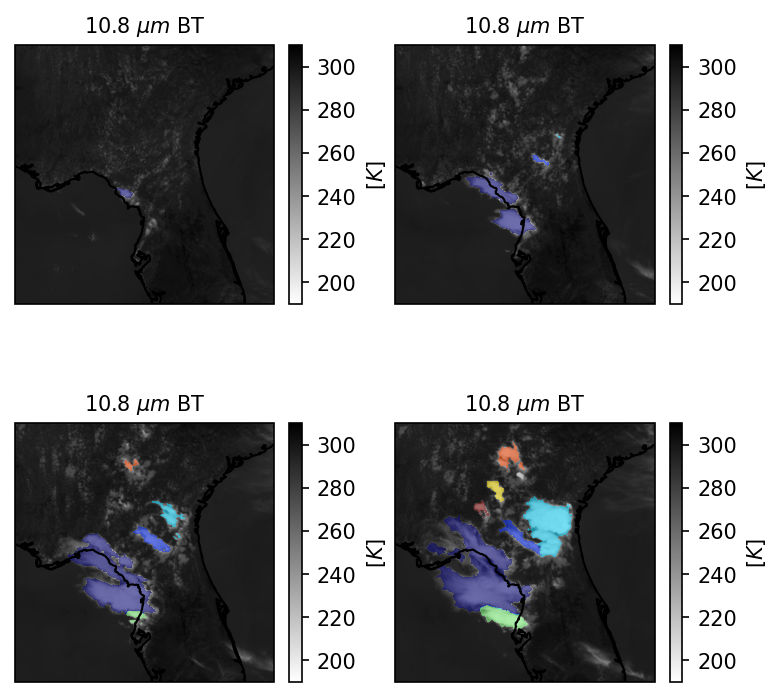

In [45]:
fig = goes_figure(dataset, dpi=150, figsize=(6,6))

ax1 = fig.subplot(221)
ax1.coastlines()
im1 = ax1.imshow(bt[12], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(thin_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thin_anvil_labels, mask=thin_anvil_labels==0)[12], cmap="jet", alpha=0.5, vmin=1, vmax=thin_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(222)
ax1.coastlines()
im1 = ax1.imshow(bt[24], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(thin_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thin_anvil_labels, mask=thin_anvil_labels==0)[24], cmap="jet", alpha=0.5, vmin=1, vmax=thin_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(223)
ax1.coastlines()
im1 = ax1.imshow(bt[36], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(thin_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thin_anvil_labels, mask=thin_anvil_labels==0)[36], cmap="jet", alpha=0.5, vmin=1, vmax=thin_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax1 = fig.subplot(224)
ax1.coastlines()
im1 = ax1.imshow(bt[-1], cmap="binary", vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
# ax1.contour(thin_anvil_labels[36], [0.5], colors=["dodgerblue"])
from numpy import ma
ax1.imshow(ma.array(thin_anvil_labels, mask=thin_anvil_labels==0)[-1], cmap="jet", alpha=0.5, vmin=1, vmax=thin_anvil_labels.max())
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

Text(0.5, 1.0, 'SWD BT difference')

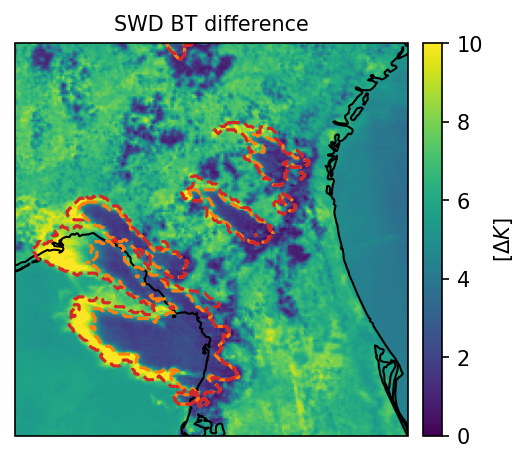

In [46]:
fig = goes_figure(dataset.isel(x=slice(50,250), y=slice(50,250)), dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
ax1.coastlines()
im1 = ax1.imshow(swd[36].isel(x=slice(50,250), y=slice(50,250)), cmap="viridis", vmin=0, vmax=10)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$\Delta K$]', fontsize=10)
ax1.contour(thick_anvil_labels[36][50:250, 50:250], [0.5], colors=["C1"], linestyles="--")
ax1.contour(thin_anvil_labels[36][50:250, 50:250], [0.5], colors=["C3"], linestyles="--")
ax1.set_title('SWD BT difference', fontsize=10)


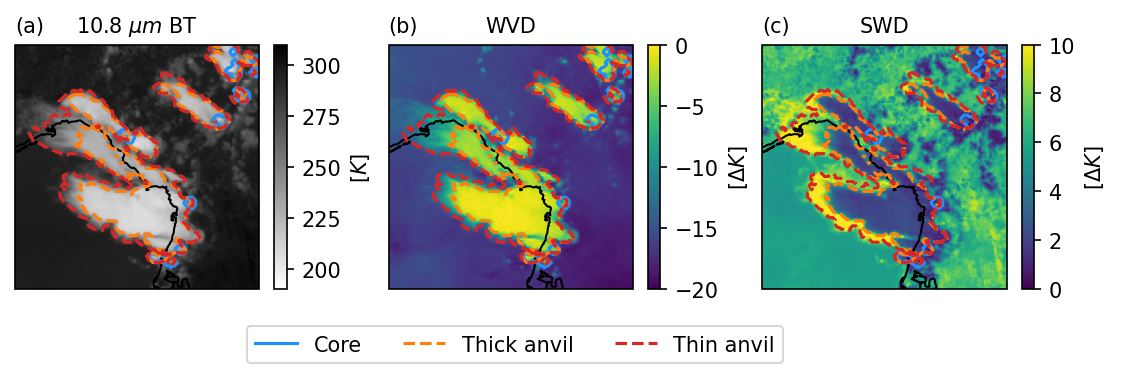

In [47]:
fig = goes_figure(dataset.isel(x=slice(50,200), y=slice(100,250)), dpi=150, figsize=(9,3))

ax1 = fig.subplot(131)
ax1.coastlines()
im1 = ax1.imshow(bt[36].isel(x=slice(50,200), y=slice(100,250)), cmap="binary", vmin=190, vmax=310)
ax1.contour(core_labels[36][100:250, 50:200], [0.5], colors=["dodgerblue"], linestyles="-")
ax1.contour(thick_anvil_labels[36][100:250, 50:200], [0.5], colors=["C1"], linestyles="--")
ax1.contour(thin_anvil_labels[36][100:250, 50:200], [0.5], colors=["C3"], linestyles="--")
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.set_title('(a)', loc='left', fontsize=10)
ax1.set_title('10.8 $\mu m$ BT', fontsize=10)

ax2 = fig.subplot(132)
ax2.coastlines()
im2 = ax2.imshow(wvd[36].isel(x=slice(50,200), y=slice(100,250)), cmap="viridis", vmin=-20, vmax=0)
ax2.contour(core_labels[36][100:250, 50:200], [0.5], colors=["dodgerblue"], linestyles="-")
ax2.contour(thick_anvil_labels[36][100:250, 50:200], [0.5], colors=["C1"], linestyles="--")
ax2.contour(thin_anvil_labels[36][100:250, 50:200], [0.5], colors=["C3"], linestyles="--")
cbar2 = ax2.colorbar(im2)
cbar2.set_label('[$\Delta K$]', fontsize=10)
ax2.set_title('(b)', loc='left', fontsize=10)
ax2.set_title('WVD', fontsize=10)

ax3 = fig.subplot(133)
ax3.coastlines()
im3 = ax3.imshow(swd[36].isel(x=slice(50,200), y=slice(100,250)), cmap="viridis", vmin=0, vmax=10)
ax3.contour(core_labels[36][100:250, 50:200], [0.5], colors=["dodgerblue"], linestyles="-")
ax3.contour(thick_anvil_labels[36][100:250, 50:200], [0.5], colors=["C1"], linestyles="--")
ax3.contour(thin_anvil_labels[36][100:250, 50:200], [0.5], colors=["C3"], linestyles="--")
cbar3 = ax3.colorbar(im3)
cbar3.set_label('[$\Delta K$]', fontsize=10)
ax3.set_title('(c)', loc='left', fontsize=10)
ax3.set_title('SWD', fontsize=10)

fig.legend([mlines.Line2D([], [], color='dodgerblue', linestyle="-"), mlines.Line2D([], [], color='C1', linestyle="--"), mlines.Line2D([], [], color='C3', linestyle="--")], 
           ['Core', 'Thick anvil', 'Thin anvil'], loc=[0.22,0.05], ncol=3)

plt.subplots_adjust(wspace=0.25)

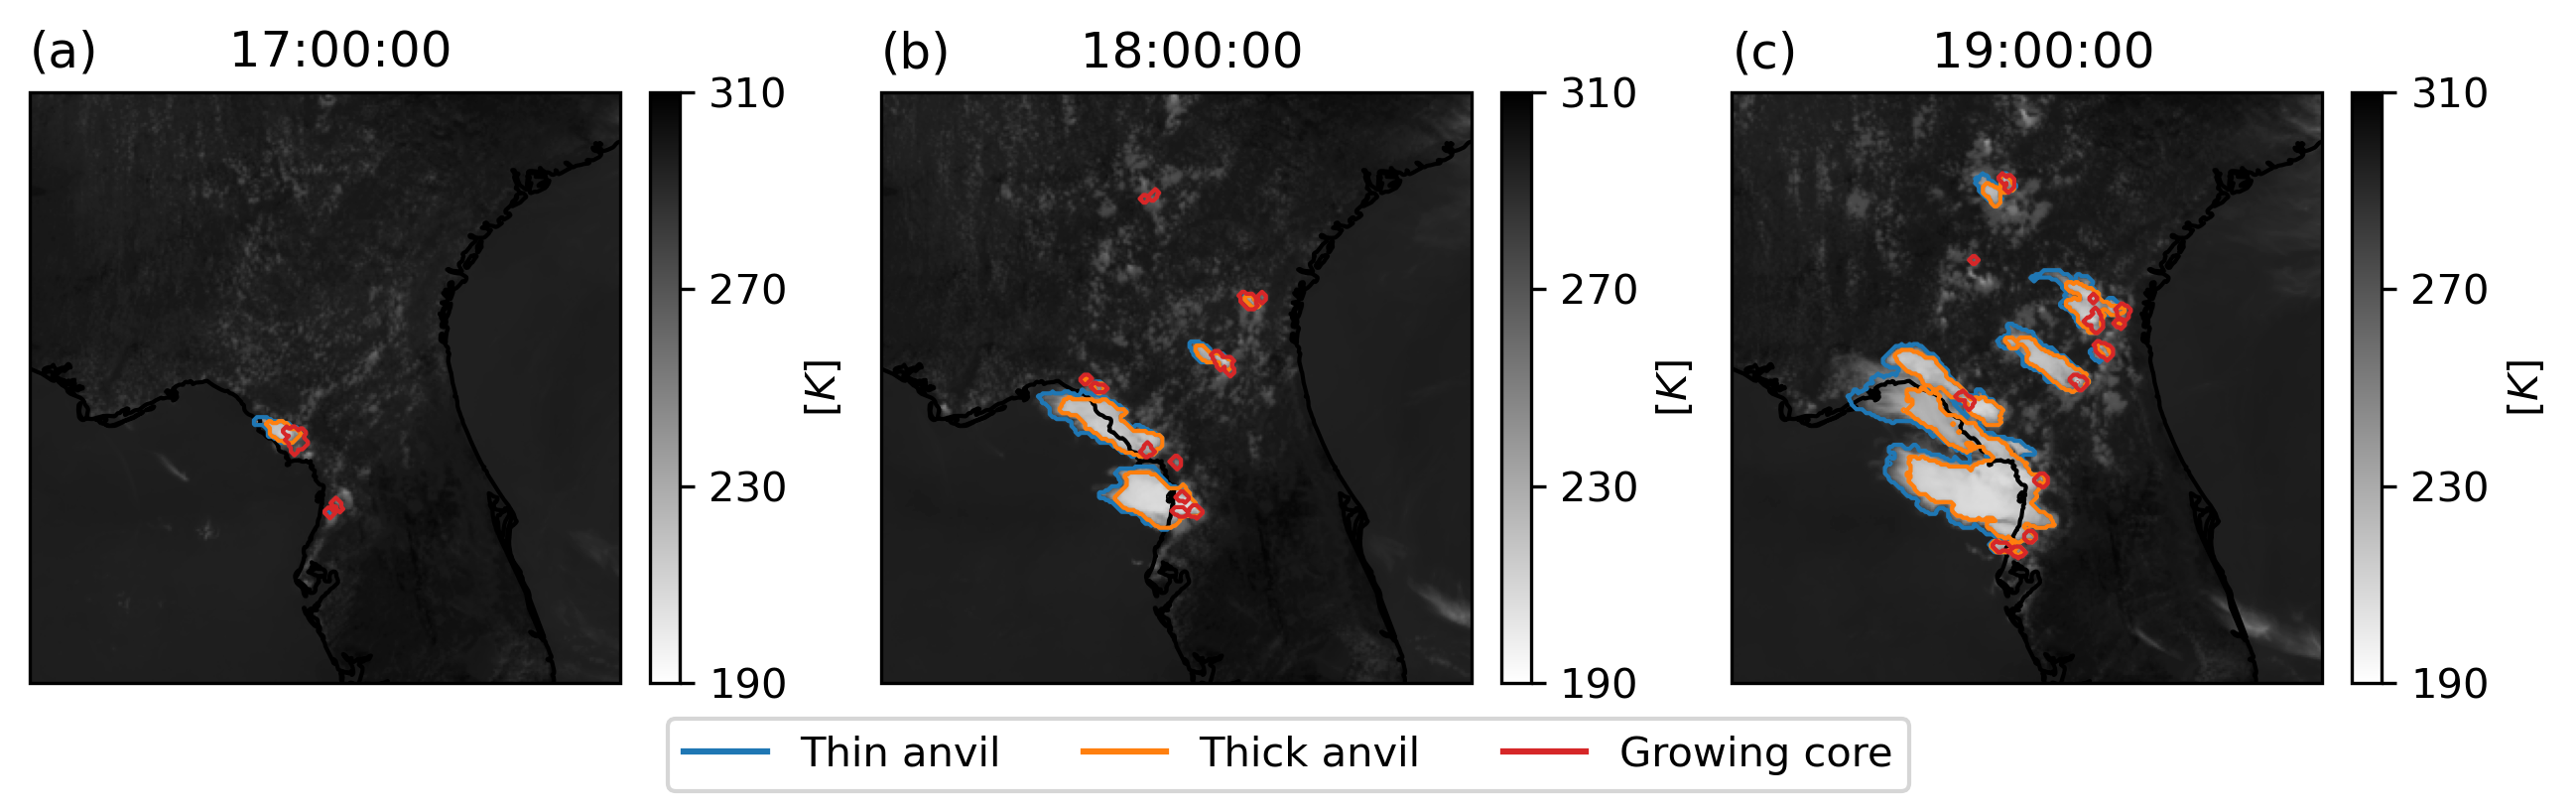

In [48]:
fig = goes_figure(dataset, dpi=300, figsize=(9,3))

i1=12
ax1 = fig.subplot(131)
ax1.coastlines()
img = ax1.imshow(bt[i1], vmin=190, vmax=310, cmap='binary')
cbar = ax1.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax1.set_title('(a)', loc='left')
ax1.set_title('  17:00:00')

ax1.contour(thin_anvil_labels[i1], [0.5], colors=['C00'], linewidths=[1])
ax1.contour(thick_anvil_labels[i1], [0.5], colors=['C01'], linewidths=[1])
ax1.contour(core_labels[i1], [0.5], colors=['C03'], linewidths=[1])

i2=24
ax2 = fig.subplot(132)
ax2.coastlines()
img = ax2.imshow(bt[i2], vmin=190, vmax=310, cmap='binary')
cbar = ax2.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax2.set_title('(b)', loc='left')
ax2.set_title('  18:00:00')

ax2.contour(thin_anvil_labels[i2], [0.5], colors=['C00'], linewidths=[1])
ax2.contour(thick_anvil_labels[i2], [0.5], colors=['C01'], linewidths=[1])
ax2.contour(core_labels[i2], [0.5], colors=['C03'], linewidths=[1])

i3=36
ax3 = fig.subplot(133)
ax3.coastlines()
img = ax3.imshow(bt[i3], vmin=190, vmax=310, cmap='binary')
cbar = ax3.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax3.set_title('(c)', loc='left')
ax3.set_title('  19:00:00')

ax3.contour(thin_anvil_labels[i3], [0.5], colors=['C00'], linewidths=[1])
ax3.contour(thick_anvil_labels[i3], [0.5], colors=['C01'], linewidths=[1])
ax3.contour(core_labels[i3], [0.5], colors=['C03'], linewidths=[1])

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C00'), mlines.Line2D([], [], color='C01'), mlines.Line2D([], [], color='C03')], 
           ['Thin anvil', 'Thick anvil', 'Growing core'], loc='lower center', ncol=3)

plt.subplots_adjust(bottom=0.05, hspace=0.1, left=0)